<a href="https://colab.research.google.com/github/MagdaPla/UNET_PPM/blob/master/Copia_de_unet_ppm_mpla_copiaG_uoc_ambVISUALITZA_imatges_PREDICIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DETECCIÓ DE ZONES AFECTADES PER PROCESSIONÀRIA A PARTIR D'IMATGES DRON I DEEP LEARNING (UNET)

In [1]:
system("sudo apt-get update")
system("sudo apt-get install -y libmagick++-dev")

install.packages("magick")
install.packages("keras")
install.packages("tfdatasets")
install.packages("tidyverse")
install.packages("rsample")
install.packages("reticulate")
install.packages("tibble")
install.packages("here")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rappdirs’, ‘config’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘forge’, ‘tfestimators’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘future’, ‘globals’, ‘furrr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [1]:
library(magick)
library(keras)
library(tfdatasets)
library(tidyverse)
library(rsample)
library(reticulate)
library(tibble)
library(here)

Linking to ImageMagick 6.9.7.4
Enabled features: fontconfig, freetype, fftw, lcms, pango, x11
Disabled features: cairo, ghostscript, rsvg, webp

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

here() starts at /content



In [0]:
# per a fer el procés reproduïble , SEMBLA QUE AIXÒ M'HA DONAT ALGUN ERROR MÉS ENDAVANT??
# no tinc clar que sigui això
#tf<-tf$compat.v1
#tf$set_random_seed(100)

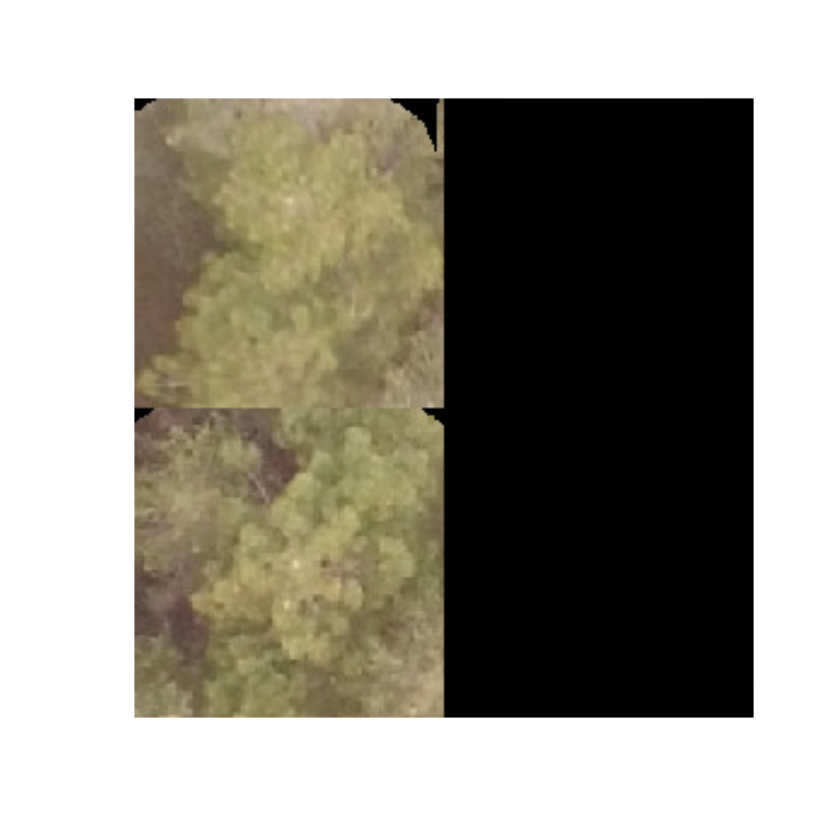

In [2]:
images <- tibble(
  img = list.files(here::here("sample_data/rgb"), full.names = TRUE),
  mask = list.files(here::here("sample_data/masc"), full.names = TRUE)
  ) %>% 
  sample_n(2) %>% 
  map(. %>% magick::image_read() %>% magick::image_resize("128x128"))

out <- magick::image_append(c(
  magick::image_append(images$img, stack = TRUE), 
  magick::image_append(images$mask, stack = TRUE)
  )
)

plot(out)

In [0]:
#Comencem a construïr el model. 
# Utilitzarem `tfdatasets` per a carregar les dades i preparar el "pipeline"

data <- tibble(
  img = list.files(here::here("sample_data/rgb"), full.names = TRUE),
  mask = list.files(here::here("sample_data/masc"), full.names = TRUE)
)

data <- initial_split(data, prop = 0.8)

In [0]:
#definim el "pipeline" per llegir els fitxers i decodificar les imatges 
# en aquest cas les tenim com a RGB en `.jpeg` i màscares en `.gif`.
# no es sap decodificar els tiff, no existeix decode_tif... així que hem transformat a jpg i gif
training_dataset <- training(data) %>%  
  tensor_slices_dataset()%>% 
  dataset_map(~.x %>% list_modify(
    img = tf$image$decode_jpeg(tf$io$read_file(.x$img)),
    mask = tf$image$decode_gif(tf$io$read_file(.x$mask))[1,,,][,,1,drop=FALSE]
  ))

In [0]:
#per veure els outputs de manera interactiva, utilitzarem:
example <- training_dataset %>% as_iterator() %>% iter_next()

In [0]:
#Carreguem les imatges en un tensor `float32` 
#amb valors entre [0,1]:
training_dataset <- training_dataset %>% 
  dataset_map(~.x %>% list_modify(
    img = tf$image$convert_image_dtype(.x$img, dtype = tf$float32),
    mask = tf$image$convert_image_dtype(.x$mask, dtype = tf$float32)
  ))

In [7]:
summary(training_dataset)

<MapDataset shapes: {img: (None, None, None), mask: (None, None, 1)}, types: {img: tf.float32, mask: tf.float32}>


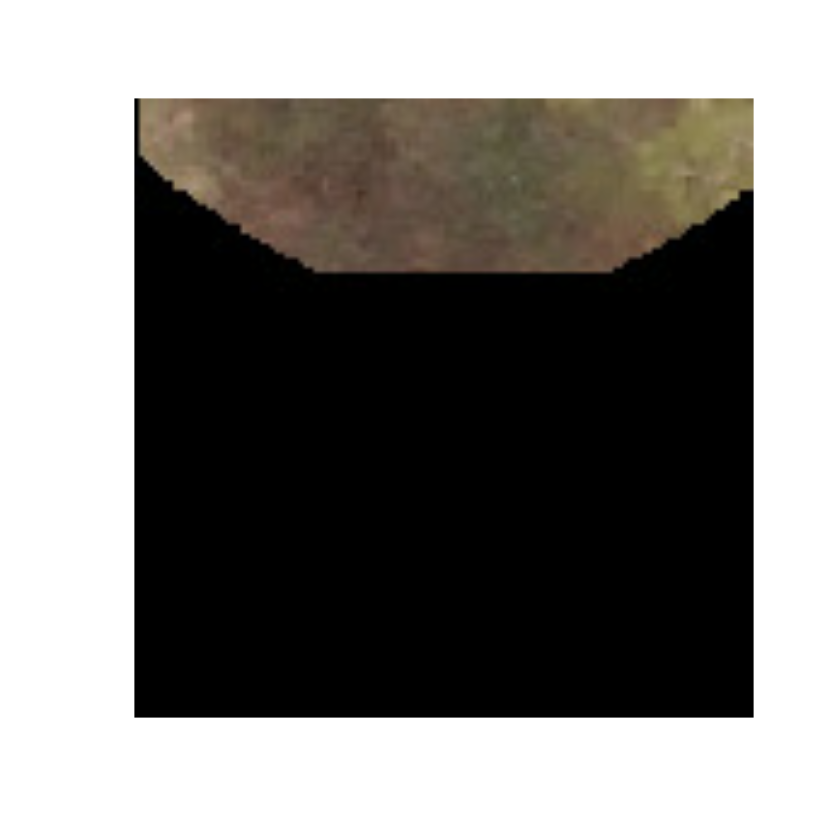

In [8]:
example <- training_dataset %>% as_iterator() %>% iter_next()
example$img %>% as.array() %>% as.raster() %>% plot()

In [0]:
# fem un procés senzill d'"augment" de les imatges
random_bsh <- function(img) {
  img %>% 
    tf$image$random_brightness(max_delta = 0.3) %>% 
    tf$image$random_contrast(lower = 0.5, upper = 0.7) %>% 
    tf$image$random_saturation(lower = 0.5, upper = 0.7) %>% 
    tf$clip_by_value(0, 1) #%>% # clip the values into [0,1] range.
    #tf$image$random_flip_left_right(seed = 100) %>%
    #tf$image$random_flip_up_down(seed = 123)
}

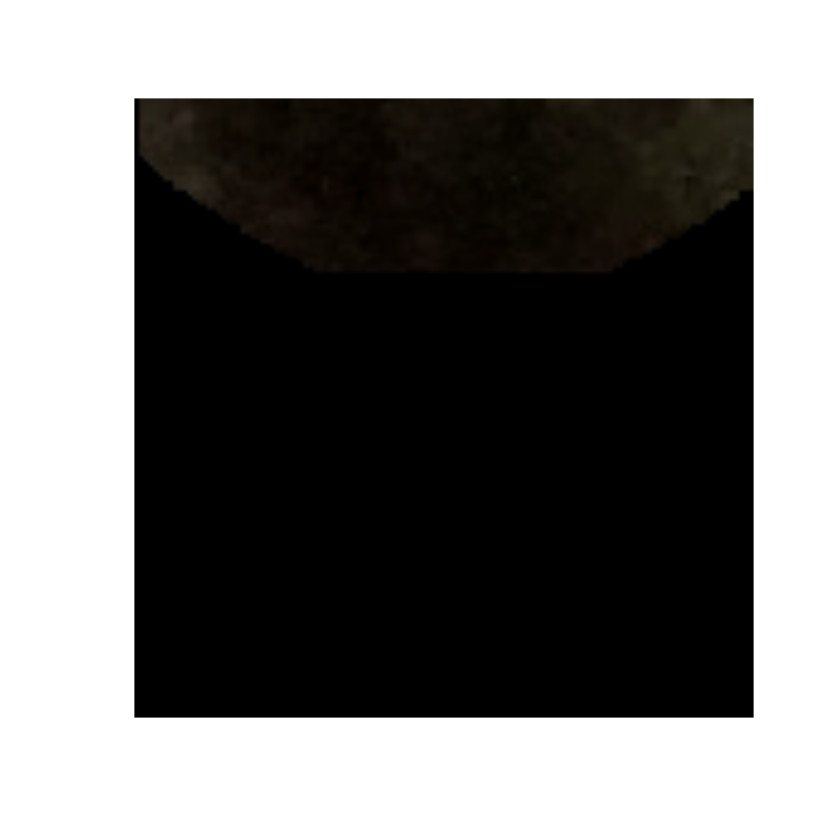

In [10]:
# veiem els efectes sobre les imatges corresponents 
training_dataset <- training_dataset %>% 
  dataset_map(~.x %>% list_modify(
    img = random_bsh(.x$img)
  ))
# plot:
example <- training_dataset %>% as_iterator() %>% iter_next()
example$img %>% as.array() %>% as.raster() %>% plot()

In [0]:
#creem una funció amb el codi anterior i alhora creem el dataset

create_dataset <- function(data, train, batch_size = 32L) {
  
  dataset <- data %>% 
    tensor_slices_dataset() %>% 
    dataset_map(~.x %>% list_modify(
      img = tf$image$decode_jpeg(tf$io$read_file(.x$img)),
      mask = tf$image$decode_gif(tf$io$read_file(.x$mask))[1,,,][,,1,drop=FALSE]
    )) %>% 
    dataset_map(~.x %>% list_modify(
      img = tf$image$convert_image_dtype(.x$img, dtype = tf$float32),
      mask = tf$image$convert_image_dtype(.x$mask, dtype = tf$float32)
    ))
  
  if (train) {
    dataset <- dataset %>% 
      dataset_map(~.x %>% list_modify(
        img = random_bsh(.x$img)
      )) 
  }
  
  if (train) {
    dataset <- dataset %>% 
      dataset_shuffle(buffer_size = batch_size*128)
  }
  
  dataset <- dataset %>% 
    dataset_batch(batch_size)
    
  dataset %>% 
    dataset_map(unname) # Keras needs an unnamed output.
}

In [12]:
data

<Analysis/Assess/Total>
<404/100/504>

In [0]:
# Creem propiament les dades d'entrenament i les de validacióa partir del dataset:
training_dataset <- create_dataset(training(data), train = TRUE)
validation_dataset <- create_dataset(testing(data), train = FALSE)

In [0]:
# a dalt hem preparat el "pipeline", ara preparem el model

# Primer definim la mètrica i "loss" de manera personalitzada: 
# mirar però si em convé més utilitzar "binari crosentropy" o aquest... valoro

dice_coef <- custom_metric("custom", function(y_true, y_pred, smooth = 1.0) {
  y_true_f <- k_flatten(y_true)
  y_pred_f <- k_flatten(y_pred)
  intersection <- k_sum(y_true_f * y_pred_f)
  result <- (2 * intersection + smooth) / 
    (k_sum(y_true_f) + k_sum(y_pred_f) + smooth)
  return(result)
})

# per calcular el paràmetre "loss" segons Wagner et al,
# valoro si cal posar-la o no, de moment he utilitzat la BinaryCrossentropy
 bce_dice_loss <- function(y_true, y_pred) {
  result <- loss_binary_crossentropy(y_true, y_pred) +
    (1 - dice_coef(y_true, y_pred))
  return(result)
}

In [15]:
# el model i la seva compilació: 
model <- keras_model_sequential()

get_unet_128 <- function(input_shape = c(128, 128, 3),
                         num_classes = 1) {
  
  inputs <- layer_input(shape = input_shape)
  # 128
  
  down1 <- inputs %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down1_pool <- down1 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 64
  
  down2 <- down1_pool %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down2_pool <- down2 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 32
  
  down3 <- down2_pool %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down3_pool <- down3 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 16
  
  down4 <- down3_pool %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down4_pool <- down4 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 8
  
  center <- down4_pool %>%
    layer_conv_2d(filters = 1024, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 1024, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  # center
  
  up4 <- center %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down4, .), axis = 3)} %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 16
  
  up3 <- up4 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down3, .), axis = 3)} %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 32
  
  up2 <- up3 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down2, .), axis = 3)} %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 64
  
  up1 <- up2 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down1, .), axis = 3)} %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 128
  
  classify <- layer_conv_2d(up1,
                            filters = num_classes, 
                            kernel_size = c(1, 1),
                            activation = "sigmoid")
  
  
  model <- keras_model(
    inputs = inputs,
    outputs = classify
  )
  
  model %>% compile(
    optimizer = optimizer_rmsprop(lr = 0.0001),
    loss = bce_dice_loss, #"BinaryCrossentropy",
    metrics = c(dice_coef)
  )
  
  return(model)
}

model <- get_unet_128()
summary(model)

Model: "model"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_1 (InputLayer)      [(None, 128, 128, 0                                   
________________________________________________________________________________
conv2d (Conv2D)           (None, 128, 128,  1792     input_1[0][0]              
________________________________________________________________________________
batch_normalization (Batc (None, 128, 128,  256      conv2d[0][0]               
________________________________________________________________________________
activation (Activation)   (None, 128, 128,  0        batch_normalization[0][0]  
________________________________________________________________________________
conv2d_1 (Conv2D)         (None, 128, 128,  36928    activation[0][0]           
________________________________________________________________________________
batch_normali

In [0]:
# creem un callbacks 
checkpoint_path <- "weights_r/cp.ckpt"

# Create checkpoint callback
cp_callback <- callback_model_checkpoint(
  filepath = checkpoint_path,
  save_weights_only = TRUE,
  save_best_only = TRUE,
  verbose = 1
)

#i ajustem el model amb les dades d'entrenament: 
history <- model %>% fit(
  training_dataset,
  epochs = 100,
  validation_data = validation_dataset, 
  callbacks = list(cp_callback), # pass callback to training,
  verbose= 2
)



`geom_smooth()` using formula 'y ~ x'



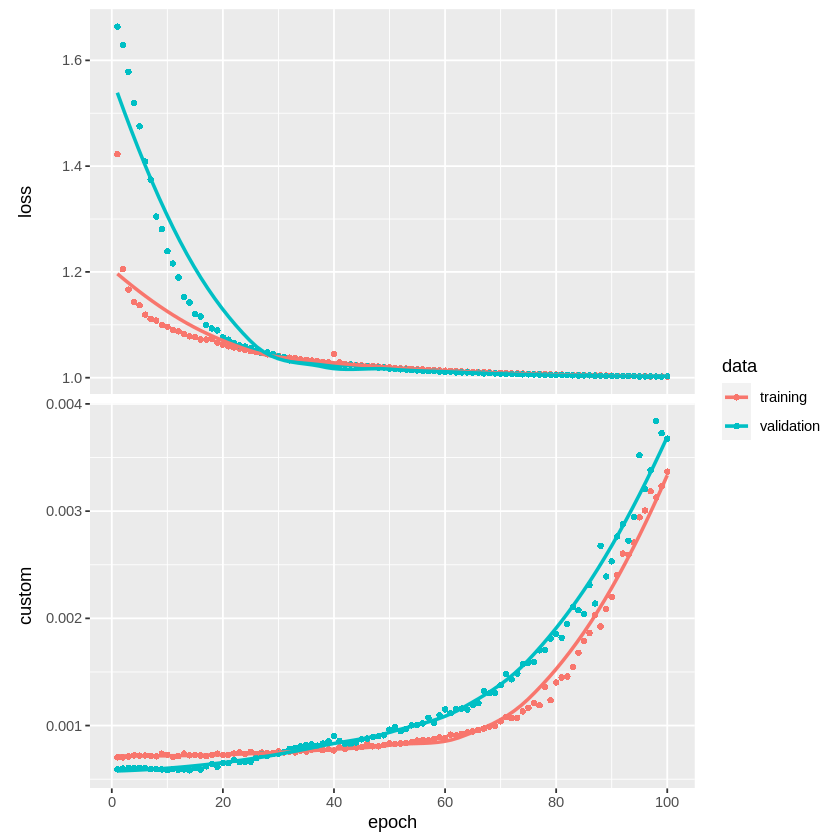

In [17]:
# veiem gràficament els ajustos de l'entrenament
plot(history)

In [18]:
print(history)


Final epoch (plot to see history):
      loss: 1.002
    custom: 0.003368
  val_loss: 1.003
val_custom: 0.003676 


In [114]:
# evaluate accuracy on the validation dataset
accuracy <- model %>% evaluate(validation_dataset,verbose = 0)
print(accuracy)

       loss      custom 
1.002739787 0.003675763 


Extraiem info de UNET de wagner per a visualitzar i agafar els resultats

In [27]:
install.packages("raster")



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘sp’




In [28]:
system("sudo apt-get update")
system("sudo apt-get install libgdal-dev libproj-dev")

install.packages("rgdal")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [21]:
library(raster)
library(rgdal)

Loading required package: sp


Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select


The following object is masked from ‘package:tidyr’:

    extract


rgdal: version: 1.5-8, (SVN revision 990)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
Path to GDAL shared files: /usr/share/gdal/2.2
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
Path to PROJ shared files: (autodetected)
Linking to sp version:1.4-2
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.



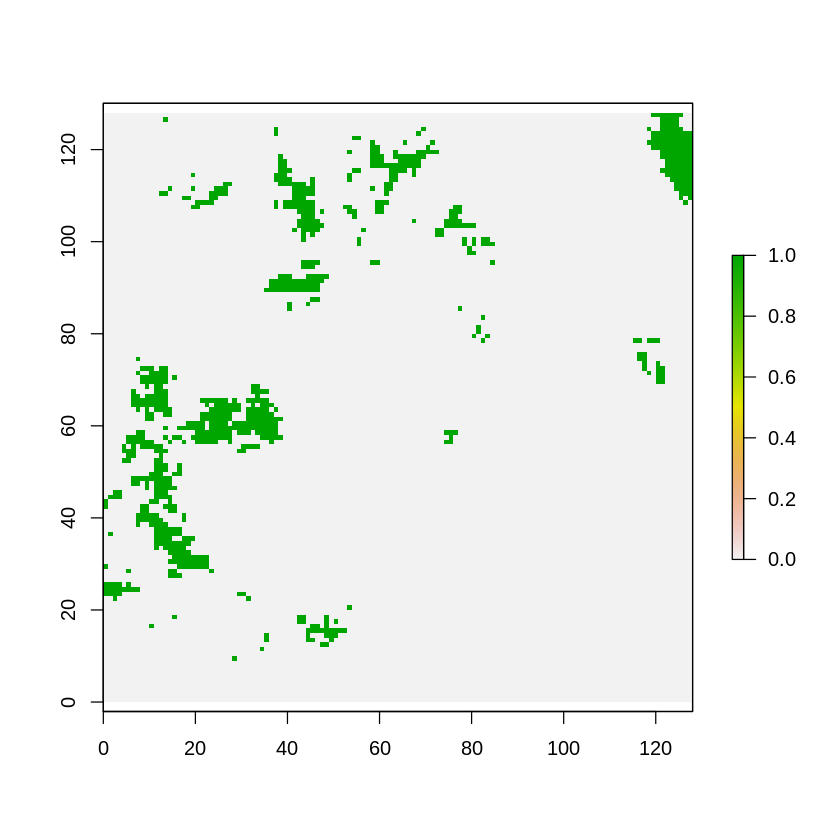

In [66]:
# altres maneres de visualitzar els rasters de sortida.
masc=brick(list.files(here::here("sample_data/masc"),full.names = TRUE)[[8]])
plot(masc)

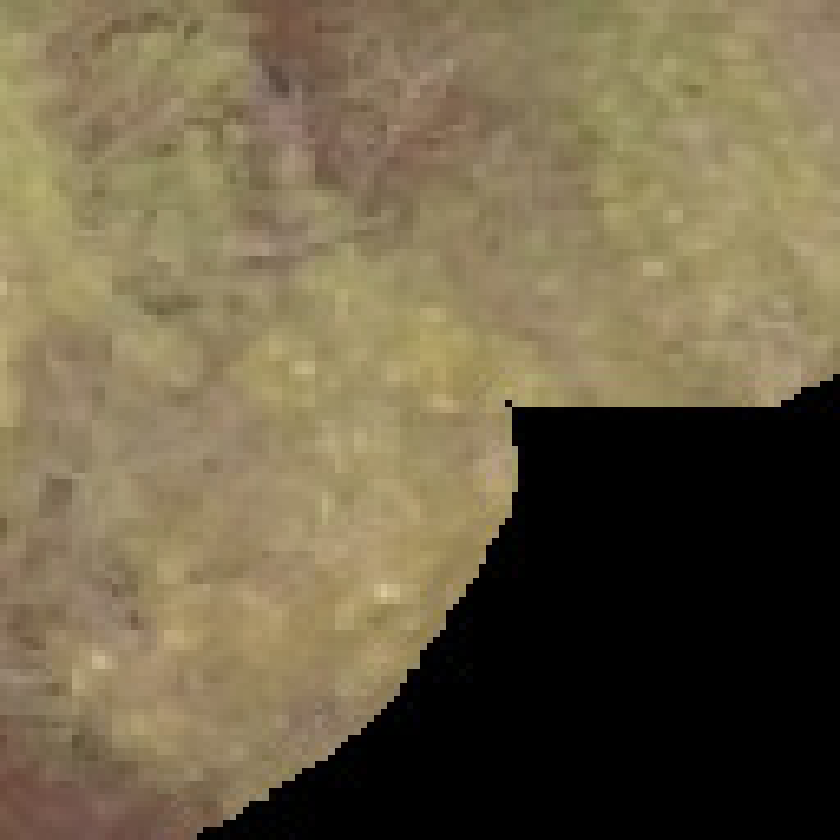

In [67]:
# la info original RGB
#img <- list.files(here::here("sample_data/rgb1"), full.names = TRUE)
img=brick(list.files(here::here("sample_data/rgb"),full.names = TRUE)[[8]])  #[8] és el número de mostra 
plotRGB(img)

In [0]:
# preparem la predicció
img_array<-array(data=NA, dim = c(128,128,1), dimnames = NULL)

In [0]:
#img_array[,,1]<-as.matrix(ifelse(t(predictions[8, , ,1 ]) > 0.10, 0, 0.16))
img_array[,,1]<-as.matrix(predictions[8, , ,1 ])


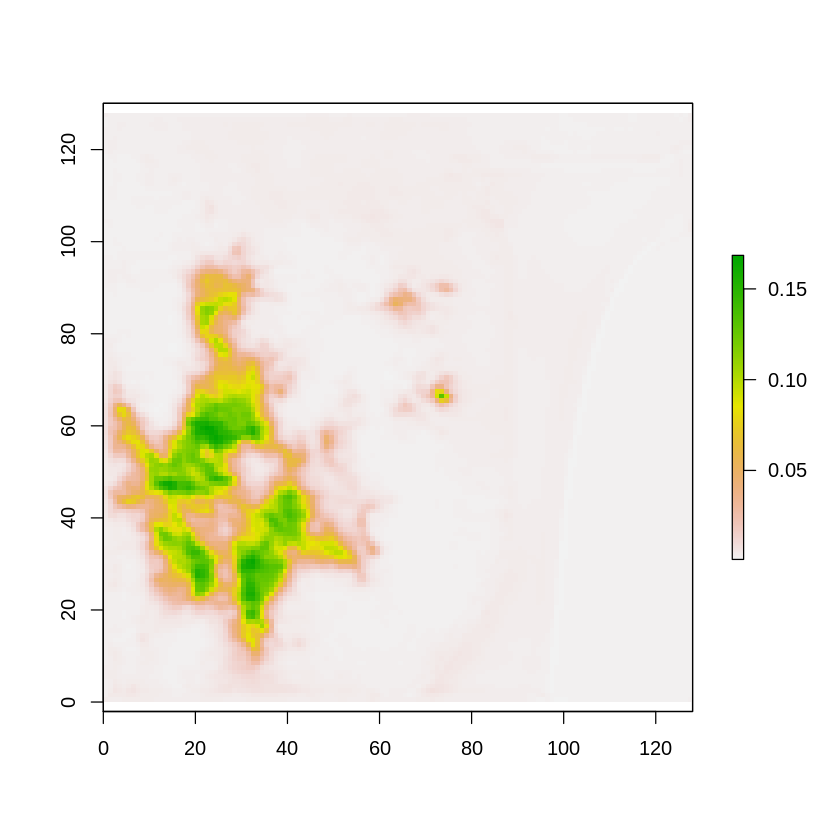

In [70]:
im_pred<-img[[1]]*0
im_pred[]<-img_array[,,1]
plot(im_pred)

In [0]:
# exemple de com guardar una de les imatges predites
kkk<- image_read(img_array)
image_write(kkk,path = "sample_data/res/8.tif", format = "tif")


NOVES PREDICCIONS A PARTIR DE NOVES DADES

In [170]:
install.packages("parallel")
install.packages("doParallel")
install.packages("foreach")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘parallel’ is not available (for R version 3.6.3)”
Warning message:
“package ‘parallel’ is a base package, and should not be updated”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘foreach’, ‘iterators’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [171]:
library(parallel)
library(doParallel)
library(foreach)

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators



In [0]:
# per a generar una predicció d'un altre dataset amb el mateix model:
# pujo les dades en el model (noves_dades) ---- em cal comprobar CODI


#carreguem les dades
new_data <- list.files(here::here("sample_data/new_rgb"), full.names = TRUE)

In [0]:
# IMPORTANT: NO TROBO LA MANERA DE ENTRAR LES NOVES DADES (NOMÉS RGB, SENSE MASC)
# PER A FER LES PREDICCIONS
predictions <- predict(model, new_data)
